# Notebook for creating general visualisations

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import math

AICOPE_PY_LIB = os.environ.get("AICOPE_PY_LIB")
if AICOPE_PY_LIB and AICOPE_PY_LIB not in sys.path: sys.path.append(AICOPE_PY_LIB)
import importlib
import aicnlp
importlib.reload(aicnlp)

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import random

%config Completer.use_jedi = False
PACSIM_DATA = os.environ.get("AICOPE_SCRATCH") + "/pacsim"

### Matrix similarity methods

In [2]:
# functions for calculating similarities
from aicnlp.similarity.matsim import rv2
importlib.reload(rv2)
rv2.calculate_rv2(None, [np.random.random((20, 40)).T, np.random.random((30, 40)).T], workers=1)[0,1]
from aicnlp.similarity.matsim import mms
mms.mms(np.random.random((20, 40)), np.random.random((30, 40)))
from aicnlp.similarity.matsim import eds
importlib.reload(eds)
eds.eds(np.random.random((20, 40)), np.random.random((30, 40)))

# import dtw

def calculate_sims(p1, p2):
    p1 += np.random.random(p1.shape)*0.001
    p2 += np.random.random(p2.shape)*0.001
    
    results = []
    
    results.append(rv2.calculate_rv2(None, [p1.T, p2.T], workers=1)[0,1])
    results.append(mms.mms(p1, p2))
    edssim, path = eds.eds(p1, p2, return_path=True)
    results.append(edssim)
    
    px = [pos[1] for pos in path]
    py = [pos[0] for pos in path]
    
    # al = dtw.dtw(p1, p2)
    # py = al.index1
    # px = al.index2
   
    return mms.cosine_similarity(p1, p2), results, (px, py)

In [3]:
# create patients with nonlinear similarity matrix
def get_nonlinear(s, fcn):
    out = []
    curout = ([0], [])
    lastr = 1
    for c in range(s):
        curr = fcn(c)
        # print(c, curr)
        if curr > lastr + 1:
            out.append(curout)
            curout = (list(range(lastr, math.floor(curr))), [c])
            lastr = math.floor(curr)
        else:
            curout[1].append(c)
    out.append(curout)
            
    return out
            
# get_nonlinear(20, lambda x: ((x/20)**0.42*20)+1)  

In [6]:
# plotting function
def make_plotshow(mats):
    ncol = len(mats)+1
    hcol = 5

    fig = make_subplots(rows=2, cols=ncol,
                        specs=[[{"type": "image"}]*ncol, [{"type": "table"}]*ncol] ,
                        column_widths=[hcol] + [(100-hcol)/(ncol-1)]*(ncol-1),
                        vertical_spacing=0.0,
                       )
    fig.add_table(
        cells=dict(
            values=[["rv2","mms", "eds"]],
            fill_color='white',),
        header=dict(
            values=[""],
            fill_color='white')
        ,row=2, col=1)

    for i, (name, ps) in enumerate(mats.items()):
        new_mat, results, path = calculate_sims(*ps)
        results = [f"{r:.2f}" for r in results]
        lastim = px.imshow(new_mat, color_continuous_scale='viridis',aspect="equal", zmin=0, zmax=1)
        fig.add_trace(lastim.data[0],  row=1, col=i+2)
        fig.add_trace(
            go.Scatter(
                x=path[0], y=path[1],
                mode='lines', marker_color="red"
            ),  row=1, col=i+2)
        fig.add_table(
            cells=dict(values=[results], fill_color='white',align=["center"]),
            header=dict(values=[name], fill_color='white'),
            row=2, col=i+2,
            
            # height=500
        )

    fig.layout.coloraxis = lastim.layout.coloraxis   
    fig.update_yaxes(scaleanchor = "x3", showgrid=False, autorange='reversed')
    fig.update_xaxes(side="top", scaleanchor = "y3", showgrid=False,  autorange=True)
    
    fig.update_layout(height=360, width=900, autosize=True, plot_bgcolor="white", showlegend=False)
    return fig

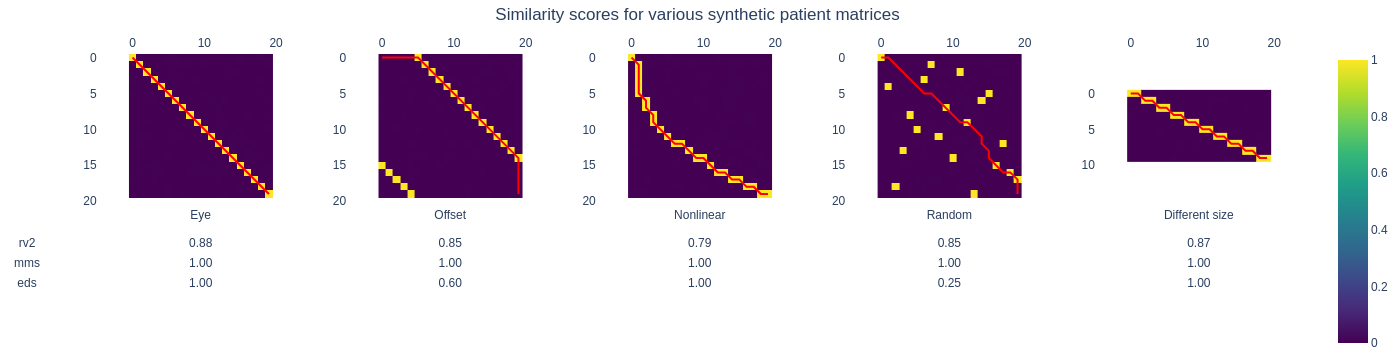

In [9]:
# define data and show plot
def mksp_distort_ps(r, c, simpairs):
    p1 = np.zeros((r, len(simpairs)))
    p2 = np.zeros((c, len(simpairs)))
    for i, (a, b) in enumerate(simpairs):
        p1[a, i] = 1
        p2[b, i] = 1
        
    return p1, p2

s = 20
shuf = list(range(20))
random.shuffle(shuf)

synplots =  {
    "Eye":  mksp_distort_ps(s, s, [(i, i) for i in range(s)]),
    "Offset": mksp_distort_ps(s, s, [(i, (i+5) % s) for i in range(s)]),
    "Nonlinear": mksp_distort_ps(20, 20, get_nonlinear(20, lambda x: ((x/20)**0.42*20)+1)  ),
    "Random": mksp_distort_ps(s, s, [(i, shuf[i]) for i in range(s)]),
    "Different size": mksp_distort_ps(s//2, s, [(i, [2*i, 2*i+1]) for i in range(s//2)]),
}

fig = make_plotshow(synplots)

fig.layout["yaxis6"].update(tickvals=(0,5,10))
fig.layout.update(
    title={"yref": "paper", "pad_b": 30, "x": 0.5, "y" : 1, "yanchor" : "bottom", "text": "Similarity scores for various synthetic patient matrices"},
    margin_t=50, margin_b=0, margin_l=0,
)
fig.update_layout(height=250, width=900, plot_bgcolor="white", showlegend=False)
fig.write_image(f"{PACSIM_DATA}/simvis/cmpmatsim-synthetic.pdf")
fig

### Patient matrices

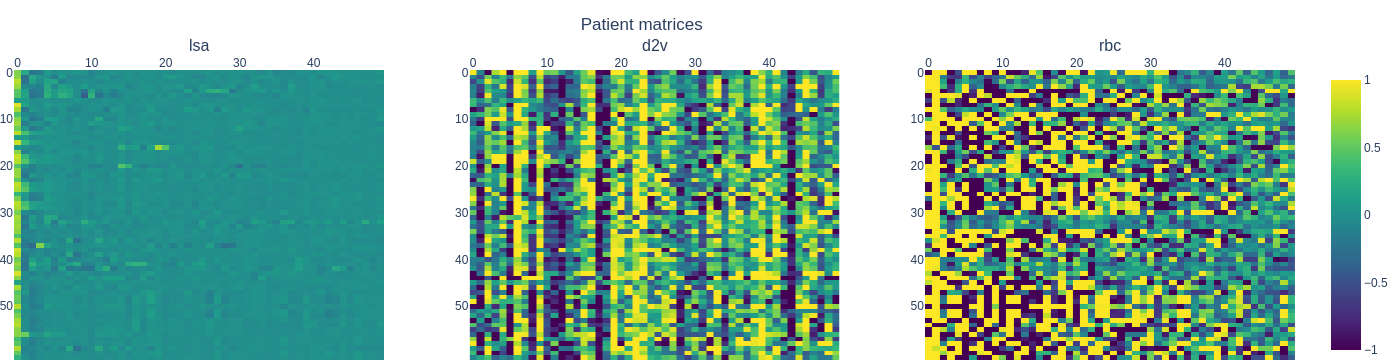

In [16]:
def show_patient_matrices(patient, vectors, fake=False):
    fig = make_subplots(
         rows=1, cols=len(vectors),
         # specs=[[{"type": "image"}]*ncol, [{"type": "table"}]*ncol] ,
         # column_widths=[hcol] + [(100-hcol)/(ncol-1)]*(ncol-1),
         # vertical_spacing=0.0,
         column_titles=list(vectors.values())
    )
    
    for i, vmethod in enumerate(vectors.keys()):
        if fake:
            mat = np.random.random((30, 50))
        else:
            df = pd.read_feather(f"{PACSIM_DATA}/2/{vmethod}-Fall.feather")
            mat = np.vstack(df.query(f"pid == {patient}")["vec"])
            # print(mat)
        lastim = px.imshow(mat, color_continuous_scale='viridis', aspect="equal", zmin=-1, zmax=1)
        fig.add_trace(lastim.data[0],  row=1, col=i+1)
        
    fig.layout.coloraxis = lastim.layout.coloraxis   
    fig.update_yaxes(showgrid=False, autorange='reversed')
    fig.update_xaxes(side="top", showgrid=False,  autorange=True)
    fig.update_layout(height=360, width=900, autosize=True, plot_bgcolor="white", showlegend=False)
    fig.update_annotations(height=45)
    fig.update_layout(margin_t=70, margin_r=0, margin_b=0, margin_l=0, height=250,
                     title={"yref": "paper", "pad_b": 40, "x": 0.46, "y" : 1, "yanchor" : "bottom", "text": "Patient matrices"},)
    return fig
    
patient = 23
fig = show_patient_matrices(patient, {"Vtfi050": "lsa", "Vd2v050": "d2v", "Vrbc050": "rbc"})
fig.write_image(f"{PACSIM_DATA}/simvis/pacmat_{patient}.pdf")
fig

### Filtering statistics

In [9]:
import glob
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

npac = 4267
filterstat = []

catmap = { 
    "Fall": "no filter",
    "Fr01": "01: Age",
    "Fr02": "02: Family history",
    "Fr03": "03: Medical history",
    "Fr04": "04: Social history",
    "Fr05": "05: Medication",
    "Fr06": "06: Allergies",
    "Fr07": "07: Tumor",
    "Fr08": "08: Treatment",
    "Fr09": "09: Treatment type",
    "Fr10": "10: Side effects",
}

for fname in tqdm(sorted(glob.glob(f"{PACSIM_DATA}/1/*.feather"))):
    df = pd.read_feather(fname)
    curpac = df["pid"].nunique()
    
    filterstat.append({
        "category": Path(fname).with_suffix("").name,
        "missing patients": npac - curpac,
        "notes": len(df),
        "notes/patient": len(df)/curpac,
    })

filterstat = pd.DataFrame.from_records(filterstat)
filterstat["category"] = filterstat["category"].map(catmap)
filterstat["notes"] = filterstat["notes"].apply(lambda x: f"{x//1000} K")
filterstat["notes/patient"] = filterstat["notes/patient"].round(1)
filterstat

  0%|          | 0/11 [00:00<?, ?it/s]

,category,missing patients,notes,notes/patient
0,no filter,0,152 K,35.7
1,01: Age,134,37 K,9.0
2,02: Family history,194,26 K,6.4
3,03: Medical history,39,59 K,14.0
4,04: Social history,176,32 K,7.9
5,05: Medication,9,71 K,16.8
6,06: Allergies,916,15 K,4.6
7,07: Tumor,0,106 K,24.8
8,08: Treatment,0,109 K,25.8
9,09: Treatment type,0,109 K,25.8


In [10]:
import re
text = filterstat.set_index("category").style.to_latex(hrules=True)
text = re.sub("lrlr", "lrrr", text)
text = re.sub(" & missing", "category & missing", text)
text = re.sub("category &  &  &  \\\\\\\\\n", "", text)
text = re.sub("00000", "", text)
print(text)

\begin{tabular}{lrrr}
\toprule
category & missing patients & notes & notes/patient \\
\midrule
no filter & 0 & 152 K & 35.7 \\
01: Age & 134 & 37 K & 9.0 \\
02: Family history & 194 & 26 K & 6.4 \\
03: Medical history & 39 & 59 K & 14.0 \\
04: Social history & 176 & 32 K & 7.9 \\
05: Medication & 9 & 71 K & 16.8 \\
06: Allergies & 916 & 15 K & 4.6 \\
07: Tumor & 0 & 106 K & 24.8 \\
08: Treatment & 0 & 109 K & 25.8 \\
09: Treatment type & 0 & 109 K & 25.8 \\
10: Side effects & 8 & 44 K & 10.6 \\
\bottomrule
\end{tabular}



### Matrix similarity timing

In [86]:
import timeit

def get_speed_mat(p1, p2, mid, nrep):
    return [
        {
            "method": "rv2",
            "dim": p1.shape[1],
            "mid": mid,
            "time": timeit.timeit(lambda: rv2.rv2(p1, p2), number=nrep) / nrep,
        },
        {
            "method": "mms",
            "dim": p1.shape[1],
            "mid": mid,
            "time": timeit.timeit(lambda: mms.mms(p1, p2), number=nrep) / nrep,
        },
        {
            "method": "eds",
            "dim": p1.shape[1],
            "mid": mid,
            "time": timeit.timeit(lambda: eds.eds(p1, p2), number=nrep) / nrep,
        },
        # {
        #     "method": "matmul",
        #     "dim": p1.shape[1],
        #     "mid": mid,
        #     "time": timeit.timeit(lambda: np.matmul(p1, p2.T), number=nrep) / nrep,
        # },
        # {
        #     "method": "dotmul",
        #     "dim": p1.shape[1],
        #     "mid": mid,
        #     "time": timeit.timeit(lambda: np.trace(np.dot(p1, p2.T)), number=nrep) / nrep,
        # },
    ]

def get_speed_dim(dims, nrep, ndim):
    results = []
    for dim in tqdm(dims):
        for mid in range(ndim):
            p1 = np.random.random((nnotes[0], dim))
            p2 = np.random.random((nnotes[1], dim))
            results.extend(get_speed_mat(p1, p2, mid, nrep))
    return results


dim = 50
nnotes = (40, 60)
nrep = 1000
results = get_speed_dim(
    dims=[50, 100, 150, 200, 250, 300, 400, 500],
    nrep=50,
    ndim=50,
)

results = pd.DataFrame.from_records(results)

  0%|          | 0/8 [00:00<?, ?it/s]

<AxesSubplot: title={'center': 'Time complexity of matrix similarity methods'}, xlabel='dimension', ylabel='time of calculation for a pair\n of patients with 40 and 60 notes [ms]'>

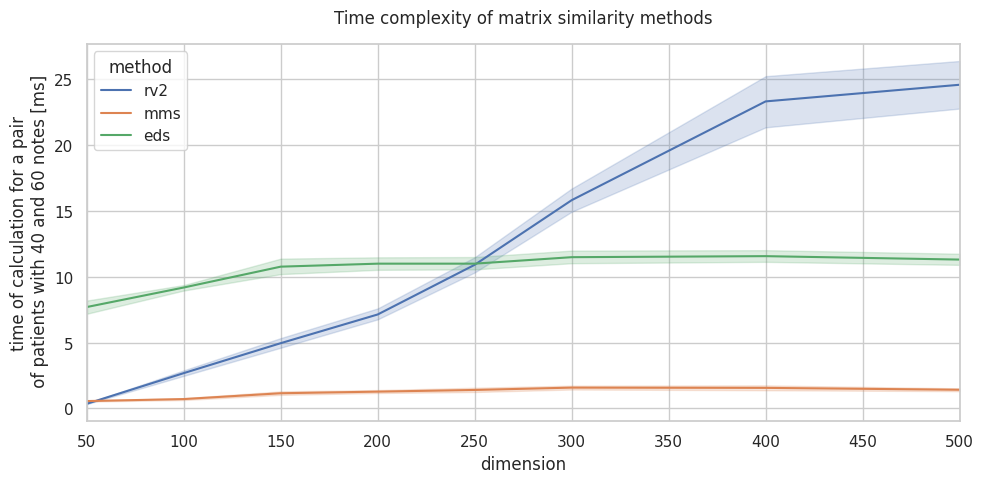

In [110]:
import seaborn as sns

def plot_speed(results):
    results = results.copy()
    results["time"] *= 1000
    rdict = {"dim": "dimension", "time": "time of calculation for a pair\n of patients with 40 and 60 notes [ms]"}
    results = results.rename(columns=rdict)
    # display(results)
    sns.set(rc={'figure.figsize':(10, 5), 'axes.titlepad': 15})
    # plt.rcParams['axes.titlepad'] = 10
    with sns.axes_style("whitegrid"):
        plt = sns.lineplot(results, x=rdict["dim"], y=rdict["time"], hue="method")
    plt.set_title("Time complexity of matrix similarity methods")
    plt.set(xlim=(50, 500))
    plt.get_figure().tight_layout()
    plt.get_figure().savefig(f"{PACSIM_DATA}/simvis/matsim_speed.pdf")
    return plt

plot_speed(results)
